In [1]:
import os
import random
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

import torch
import swifter
from torch import nn, Tensor
from torch.autograd import Variable
import pandas as pd
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import KBinsDiscretizer
from torch.optim import Adam, lr_scheduler
from torch.nn import BCEWithLogitsLoss
from torchinfo import summary
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

from mlflow import MlflowClient
import mlflow

/tmp/ipykernel_1146384/2598734477.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
class MLFlowLogger:
    def __init__(self,exp_name,
                 config:dict,
                 tracking_url:str = "http://127.0.0.1:5000",
                 ) -> None:
        
        self.client = MlflowClient(tracking_uri=tracking_url)
        self._experiment = mlflow.set_experiment(
            exp_name
        )
        
        with mlflow.start_run() as run:
            self.run_info = run.info
        
        self.track_params(config=config)
        
    
    def track_params(self, config:dict):
        params = MLFlowLogger.unnest_dictionary(config)
        
        with mlflow.start_run(run_id=self.run_info.run_id) as run:
            if not self.run_info:
                self.run_info = run.info
            
            mlflow.log_params(params)
        
        
    def track_metrics(self, metrics:dict):
        params = MLFlowLogger.unnest_dictionary(metrics)
        
        with mlflow.start_run(run_id=self.run_info.run_id) as run:
            if not self.run_info:
                self.run_info = run.info
            
            mlflow.log_metrics(metrics)
        
    
    @staticmethod
    def unnest_dictionary(d:dict, level:str=None, unnested_dict:dict = {}) -> dict:
        for k, v in d.items():
            if level:
                next_level=f"{level}_{k}"
            else:
                next_level = k
                
            if not isinstance(v,dict):
                #print(level,k)
                unnested_dict[next_level] = v
            else:
                #print(d,level,k,v,2)
                MLFlowLogger.unnest_dictionary(v, next_level, unnested_dict)
                
        return unnested_dict

In [3]:
#config of run

config = {
    "dataset":{
        "name":'toxicity_agent',
        "encoding":"proteinbert",
        "data_loc": "processed_data",
        'model_checkpoint': "facebook/esm2_t6_8M_UR50D",
    },
    "model":{
        "max_length_tokens": 400,
        },
    'batch_size': 256,
    'train_epoch': 20,
    "device": "cuda",
    "seed": 49
}

#set seeds
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

#device
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#mlflow
run_tracker = MLFlowLogger(
    f"{config['dataset']['name']}_{config['dataset']['encoding']}",
    config)

In [4]:
def get_esm2_components(config,device):

    model_checkpoint = config["dataset"]['model_checkpoint']

    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    esm2_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint).to(device)
    
    return tokenizer, esm2_model

tokenizer, esm2_model = get_esm2_components(config,device)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
tokenizer

EsmTokenizer(name_or_path='facebook/esm2_t6_8M_UR50D', vocab_size=33, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<cls>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [6]:
esm2_model.to(device)
esm2_model.esm.embeddings

EsmEmbeddings(
  (word_embeddings): Embedding(33, 320, padding_idx=1)
  (dropout): Dropout(p=0.0, inplace=False)
  (position_embeddings): Embedding(1026, 320, padding_idx=1)
)

In [7]:
train_dataset = pd.read_csv(f"{config['dataset']['data_loc']}/train.csv")
valid_dataset = pd.read_csv(f"{config['dataset']['data_loc']}/valid.csv")
test_dataset = pd.read_csv(f"{config['dataset']['data_loc']}/test.csv")

In [8]:
_l = pd.Series(train_dataset.loc[:,"Drug"].unique()).str.len()
_l.min(), _l.max()

(2, 342)

<Axes: >

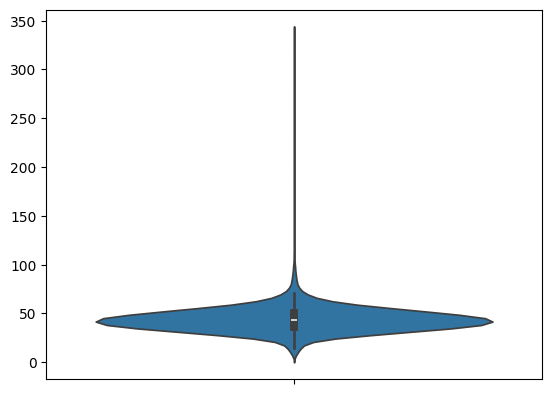

In [9]:
sns.violinplot(_l)

<Axes: >

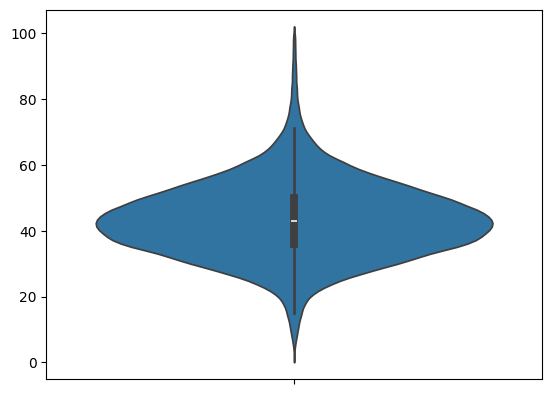

In [10]:
sns.violinplot(_l[(_l<=100)])

In [11]:
(train_dataset.shape,
 valid_dataset.shape,
 test_dataset.shape,
 )

((235958, 4), (37731, 4), (72080, 4))

In [12]:
def esm2_tokernized_encoding_drug(dataset):
    unique_drug = dataset["Drug"].unique().tolist()
    unique_drug_tokens = tokenizer(
        unique_drug,
        padding='max_length',
        max_length=config['model']['max_length_tokens'],
        truncation=True
        )
    
    unique_dict_input_ids = dict(zip(unique_drug, unique_drug_tokens["input_ids"]))
    unique_dict_attention_mask = dict(zip(unique_drug, unique_drug_tokens["attention_mask"]))
    drug_enc_input_ids = dataset["Drug"].apply(lambda x:unique_dict_input_ids[x]).to_numpy()
    drug_enc_attention_mask = dataset["Drug"].apply(lambda x:unique_dict_attention_mask[x]).to_numpy()

    return drug_enc_input_ids, drug_enc_attention_mask

# Example usage:
train_tokens = esm2_tokernized_encoding_drug(train_dataset)
valid_tokens = esm2_tokernized_encoding_drug(valid_dataset)
test_tokens = esm2_tokernized_encoding_drug(test_dataset)

KeyboardInterrupt: 

In [ ]:
class DrugDataset(Dataset):
    def __init__(self, ids, ds_name, Drug, Drug_input_ids, Drug_att_mask,  y):
        super(DrugDataset, self).__init__()
        self._ids = ids
        self.ds_name = ds_name
        self.Drug = Drug
        self.Drug_input_ids = Drug_input_ids
        self.Drug_att_mask= Drug_att_mask
        self.y = y

    def __getitem__(self, ind):
        return (self._ids[ind], 
                self.ds_name,
                self.Drug[ind],
                torch.Tensor(self.Drug_input_ids[ind]), 
                torch.Tensor(self.Drug_att_mask[ind]),
                self.y[ind])

    def __len__(self):
        return self.Drug_input_ids.shape[0]

In [ ]:
#train dataset
train_dt = DrugDataset(
    train_dataset["Drug_ID"].tolist(), 
    train_dataset["ds_name"].tolist(),
    train_dataset["Drug"].tolist(),
    train_tokens[0], 
    train_tokens[1], 
    train_dataset["Y"].tolist()
    )

#train loader
train_dl = DataLoader(
    train_dt, 
    batch_size=config['batch_size'], 
    shuffle=True, 
    pin_memory=True, 
    drop_last=True
    )

#valid dataset
valid_dt = DrugDataset(
    valid_dataset["Drug_ID"].tolist(), 
    valid_dataset["ds_name"].tolist(),
    valid_dataset["Drug"].tolist(),
    valid_tokens[0], 
    valid_tokens[1], 
    valid_dataset["Y"].tolist()
    )

#valid loader
valid_dl = DataLoader(
    valid_dt, 
    batch_size=config['batch_size'], 
    shuffle=True, 
    pin_memory=True, 
    drop_last=True
    )

#test dataset
test_dt = DrugDataset(
    test_dataset["Drug_ID"].tolist(), 
    test_dataset["ds_name"].tolist(),
    test_dataset["Drug"].tolist(),
    test_tokens[0], 
    test_tokens[1], 
    test_dataset["Y"].tolist()
    )

#test loader
test_dl = DataLoader(
    test_dt, 
    batch_size=config['batch_size'], 
    shuffle=True, 
    pin_memory=True, 
    drop_last=True
    )

In [ ]:
def embedding_step(dataloader, device, desc="processing"):
    esm2_model.eval()
    step_embeddings = []
    step_ds = []
    y_true = []

    with tqdm(dataloader, unit="batch", desc=desc) as tepoch:
        for batch in tepoch:
            _, ds, drug_input_ids, drug_att_mask, y_batch = batch
            
            drug_input_ids = drug_input_ids.long().to(device)
            drug_att_mask = drug_att_mask.long().to(device)
            
            X_drug = esm2_model.esm.embeddings(drug_input_ids, drug_att_mask)
            X_drug = esm2_model.esm.encoder(X_drug)
            X_drug = X_drug.last_hidden_state
            
            step_embeddings.append(X_drug[:,0,:].detach().cpu().numpy())
            y_true.append(y_batch.detach().cpu().numpy())
            step_ds.append(ds)

            # convert feature vector into action class

    return (np.concatenate(step_embeddings, axis=0), 
            np.concatenate(y_true, axis=0), 
            np.concatenate(step_ds, axis=0))

In [ ]:
#calculate train embeddings
train_embeddings, train_y = embedding_step(train_dl, device, desc="train embeddings")

#calculate valid embeddings
valid_embeddings, valid_y = embedding_step(valid_dl, device, desc="valid embeddings")

#calculate test embeddings
test_embeddings, test_y = embedding_step(test_dl, device, desc="test embeddings")

train embeddings:   0%|          | 0/921 [00:00<?, ?batch/s]

valid embeddings:   0%|          | 0/147 [00:00<?, ?batch/s]

test embeddings:   0%|          | 0/281 [00:00<?, ?batch/s]

In [ ]:
train_embeddings.shape, valid_embeddings.shape, test_embeddings.shape

((235776, 320), (37632, 320), (71936, 320))

In [ ]:
del esm2_model
del tokenizer
torch.cuda.empty_cache()

In [ ]:
#initialize xgboost model
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    device='gpu',
    scale_pos_weight=5,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=config["seed"]
    )

In [ ]:
xgb_model.fit(train_embeddings, train_y)
train_preds = xgb_model.predict(train_embeddings)
print(classification_report(train_y, train_preds))

              precision    recall  f1-score   support

       False       0.95      0.93      0.94    215984
        True       0.36      0.45      0.40     19792

    accuracy                           0.89    235776
   macro avg       0.66      0.69      0.67    235776
weighted avg       0.90      0.89      0.89    235776



In [ ]:
valid_preds = xgb_model.predict(valid_embeddings)
print(classification_report(valid_y, valid_preds))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96    215984
        True       0.84      0.11      0.19     19792

    accuracy                           0.92    235776
   macro avg       0.88      0.55      0.57    235776
weighted avg       0.92      0.92      0.90    235776



In [ ]:
test_preds = xgb_model.predict(test_embeddings)
print(classification_report(test_y, test_preds))

              precision    recall  f1-score   support

       False       0.94      0.91      0.92     65927
        True       0.28      0.40      0.33      6009

    accuracy                           0.86     71936
   macro avg       0.61      0.65      0.63     71936
weighted avg       0.89      0.86      0.87     71936



### Dataset Wise Analysis

In [ ]:
test_dataset["Y_pred"] = test_preds

for ds in test_dataset["ds_name"].unique():
    ds_df = test_dataset[test_dataset["ds_name"]==ds]
    print(f"\n\n Dataset:- {ds}")
    print(classification_report(ds_df["Y"], ds_df["Y_pred"]))

ValueError: Length of values (71936) does not match length of index (72080)